In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner

import jax
import numpyro.handlers as handlers

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('matplotlibrc')

In [2]:
from models.gcepy_model import EbinPoissonModelGCEPy

In [3]:
ebinmodel_gcepy = EbinPoissonModelGCEPy()

In [4]:
output_dir = '../output/posteriors'

In [5]:
svi_results = ebinmodel_gcepy.fit_SVI_at_bin(
    ie=0,
    rng_key=jax.random.PRNGKey(42),
    n_steps=10000,
    guide="iaf",
    #num_base_mixture=8,
    lr=1e-4,
    num_flows=5,
    hidden_dims=[256, 256],
    num_particles=8,
)

100%|█████████| 10000/10000 [00:18<00:00, 545.48it/s, init loss: 1904362782720.0000, avg. loss [9501-10000]: 93040.5547]


In [6]:
samples = ebinmodel_gcepy.get_svi_samples(num_samples=50000, expand_samples=True)
pickle.dump((samples, svi_results), open(f'{output_dir}/compare_gcepy/gcepy_svi.p', 'wb'))

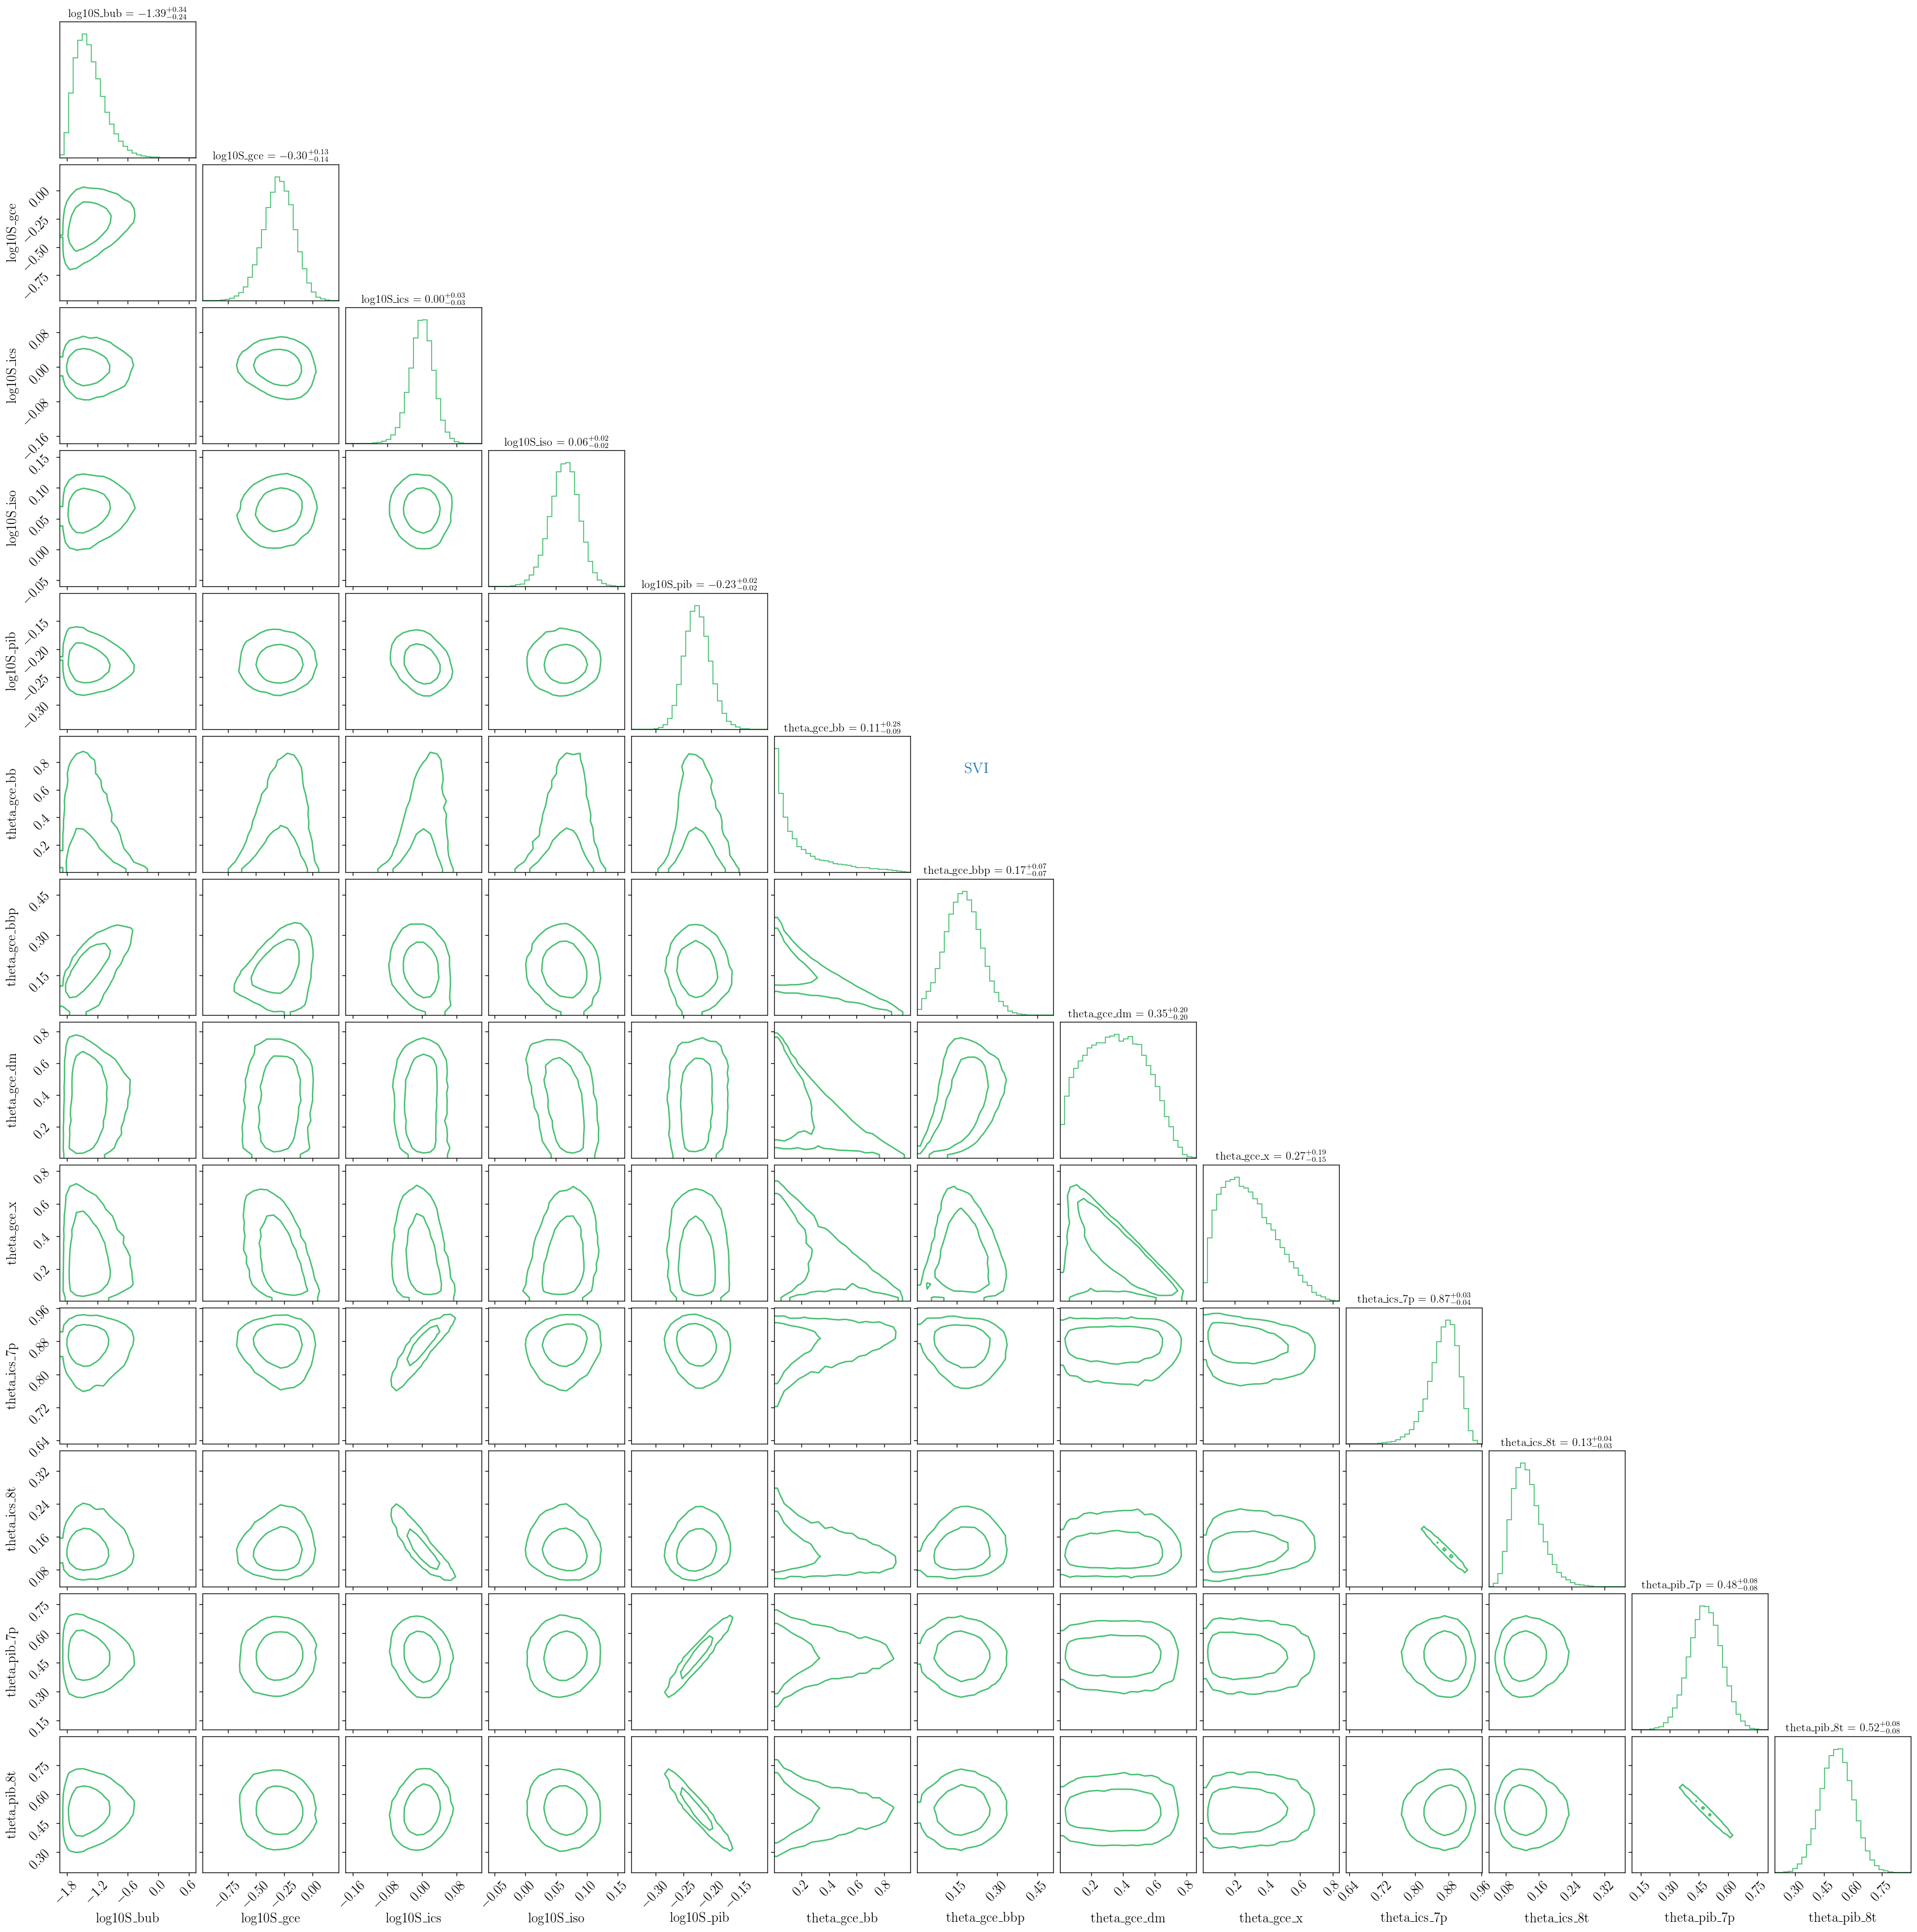

In [7]:
s0, _ = pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi.p', 'rb'))
#s1 = expand_samples(pickle.load(open(f'{output_dir}/check_SVI/ebin10_pthmc.p', 'rb')))
samples_dict = {
    'SVI' : s0,
    #'PTHMC' : s1,
}
colors_dict = {
    'SVI' : mpl.cm.get_cmap('viridis')(0.7),
    #'PTHMC' : mpl.cm.get_cmap('binary')(0.5),
}

plot_var_names = list(s0.keys())

n_bins_1d = 30
bins_1d_arr = []
for vn in plot_var_names:
    vmin = np.min([np.min(s[vn]) for _, s in samples_dict.items()])
    vmax = np.max([np.max(s[vn]) for _, s in samples_dict.items()])
    bins_1d_arr.append(np.linspace(vmin, vmax, n_bins_1d + 1))

figure = None
for i, (samples_name, samples) in enumerate(samples_dict.items()):
    color = f'C{i}'
    figure = corner.corner(
        samples,
        bins_1d_arr=bins_1d_arr,
        var_names=plot_var_names,
        show_titles=True,
        title_kwargs={"fontsize": 12},
        levels = [0.68, 0.95],
        #color = mpl.colors.to_hex(mpl.colors.to_rgb(f'C{i}') + (alphas[i],), keep_alpha=True),
        color = mpl.colors.to_hex(colors_dict[samples_name]),
        plot_contours=True,
        fill_contours=False,
        plot_density=False,
        plot_datapoints=False,
        fig=figure,
        #alpha=alphas[i]
    )
    figure.text(0.5, 0.6+0.012*i, samples_name, fontsize=16, color=color)

# ndim = len(plot_var_names)
# axs = np.array(figure.axes).reshape((ndim, ndim))

# MAP_estimates, _ = pickle.load(open(f'{output_dir}/check_SVI/ebin10_MAP.p', 'rb'))

# for i, v in enumerate(plot_var_names):
#     axs[i,i].axvline(MAP_estimates[v], color='k')
    
# for ri in range(ndim):
#     for ci in range(ri):
#         axs[ri,ci].plot(MAP_estimates[plot_var_names[ci]], MAP_estimates[plot_var_names[ri]], '*', color='k', ms=10)